## Taylor-Green flow

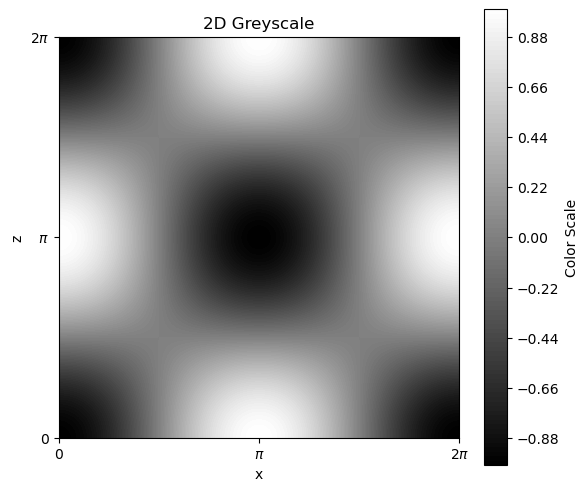

In [98]:
import numpy as np
import matplotlib.pyplot as plt

def psi(x, z):
    return -np.cos(x) * np.cos(z)

# plot the function in 2D greyscale (x, z) -> f(x, z)
fig, ax = plt.subplots(figsize=(6,6))
X = np.linspace(0, 2*np.pi, 100)
Z = np.linspace(0, 2*np.pi, 100)
X, Z = np.meshgrid(X, Z)
Y = psi(X, Z)

contour = ax.contourf(X, Z, Y, 100, cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('z')

# set the tickers to only show pi and 2pi
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels(['0', '$\pi$', '$2\pi$'])
ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])
ax.set_aspect('equal')
ax.set_title('2D Greyscale')
# set bar to show the color scale
cbar = fig.colorbar(contour, shrink=0.8)
cbar.ax.set_ylabel('Color Scale')

plt.tight_layout()
plt.show()


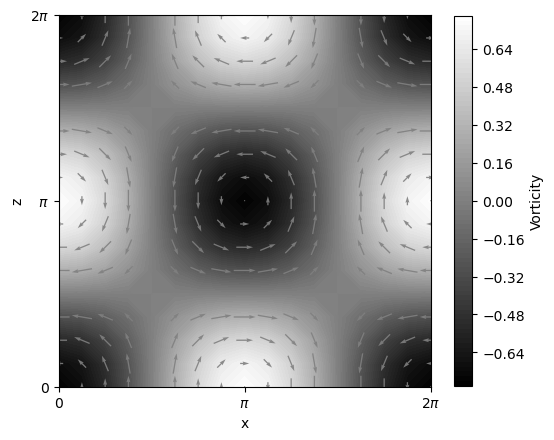

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def u(x, z):
    return -np.cos(x) * np.sin(z)

def v(x, z):
    return np.sin(x) * np.cos(z)

# define function w(u,v) caculate vorticity of the vector field
def w(u, v):# w = d(v)/dx - d(u)/dy
    return np.gradient(v, axis=1) - np.gradient(u, axis=0)

# plot the vector graph of Taylor-Green vortex
fig, ax = plt.subplots(figsize=(6,6))
X, Z = np.meshgrid(np.linspace(0, 2*np.pi, 17), np.linspace(0, 2*np.pi, 17))
U = u(X, Z)
V = v(X, Z)
contour = ax.contourf(X, Z, -w(U, V), 100, cmap='gray')
ax.quiver(X, Z, U, V, angles='uv', scale_units='xy', scale=2.5, pivot='mid', alpha=0.9, color='grey')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_aspect('equal')
# set the tickers to only show pi and 2pi
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels(['0', '$\pi$', '$2\pi$'])
ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])
cbar = fig.colorbar(contour,shrink=0.8)
cbar.ax.set_ylabel('Vorticity')
plt.show()


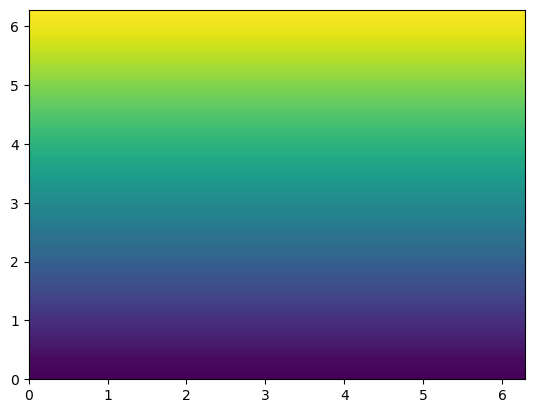

In [95]:
plt.contourf(X, Z, np.gradient(Z**2,axis=0),100)

## Learning Gymnasium and Baseline3

In [3]:
# Path: TGF.ipynb
# Reinforcement Learning
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import sys
# 定义涡场和动力学方程
def omega_hat(x, z, length = 1):
    if length == 1:
        return np.cos(x)*np.cos(z)
    elif length == 3:
        return np.array([0,0,np.cos(x)*np.cos(z)])
        
def u_hat(x, z):
    return np.array([-np.cos(x)*np.sin(z)/2, np.sin(x)*np.cos(z)/2])

def eta(): # eta = (eta_x, eta_z)
    return np.random.normal(0, 1, 2)

def xi():
    return np.random.normal(0, 1)

def p(theta_p, length = 2): # p = (p_x, p_z) (default) or (p_x, p_z, p_y) (length = 3)
    if length == 2:
        return np.array([np.cos(theta_p),np.sin(theta_p)])
    elif length == 3:
        return np.array([np.cos(theta_p),np.sin(theta_p),0])
    
def delta_X(x, z, theta_p, Phi, D0, u0): # delta_X = (delta_x, delta_z)
    return u0*(u_hat(x, z)+Phi*np.array([np.cos(theta_p),np.sin(theta_p)]))+np.sqrt(2*D0)*eta()

def delta_theta_p(x, z, theta_p, ka, Psi, B, DR):
    delta_p0 = 1/(2*B) * ((ka-np.dot(ka,p(theta_p))*p(theta_p))+Psi* np.cross(omega_hat(x, z, 3),p(theta_p, 3))[:2])
    return np.linalg.norm(delta_p0)+ np.sqrt(2*DR)*xi()

# dictOfVorticity = {0: "w-",1: "w0",2: "w+"}
# dictOfDirection = {0: "up",1: "left",2: "down",3: "right"}
# dictOfActions = {0: "up",1: "left",2: "down",3: "right"}

# 定义环境
class CustomEnv(gym.Env): # 继承gym.Env类
    def __init__(self, Phi = 0, Psi = 0, B = 1, u0 = 1, D0 = 1, DR = 1, dt = 0.1): # 初始化函数
        super(CustomEnv, self).__init__() # 必须调用父类的构造函数
        self.Phi = Phi
        self.Psi = Psi
        self.B = B
        self.u0 = u0
        self.D0 = D0
        self.DR = DR
        self.dt = dt
        # 定义观测空间, 状态空间和动作空间
        # Observation space will be a dict of two discrete values
        self.observation_space = spaces.Dict({
            "vorticity": spaces.Discrete(3),# dictOfVorticity.keys()
            "direction": spaces.Discrete(4)# dictOfDirection.keys()
        })
        # State space will be a dict of two continuous values
        self.low = np.array([0,0])
        self.high = np.array([2*np.pi,2*np.pi])
        self.state_space = spaces.Dict({
            "position" : spaces.Box(self.low, self.high, dtype=np.float32),
            "direction_theta_p": spaces.Box(low = 0, high = 2*np.pi, shape = (1,), dtype=np.float32)
            })
        # Action space will be a discrete set of 4 actions
        self.action_space = spaces.Discrete(4)# dictOfActions.keys()
        # 定义动作到方向的映射字典
        self._action_to_ka = {
            0: np.array([0, 1]),
            1: np.array([-1, 0]),
            2: np.array([0, -1]),
            3: np.array([1, 0]),
        }
        # 初始化状态和观测
        self.observation = self.reset()
        
    def reset(self, seed = None, initial_position = None, initial_direction = None):    
        super().reset(seed=seed) # 重置环境   
        self.state = self.state_space.sample() # 初始化状态
        if initial_position is not None:
            self.state["position"] = initial_position.copy()
        if initial_direction is not None:
            self.state["direction_theta_p"] = initial_direction.copy()
        self.observation = self._get_obs()
        info = {'position': self.state['position']} # 初始化信息 
        return self.observation, info # 返回初始化状态
    
    def step(self, action):
        # dynamics
        ka = self._action_to_ka[action]
        delta_x = delta_X(self.state["position"][0], self.state["position"][1], self.state["direction_theta_p"][0], self.Phi, self.D0, self.u0)
        self.state["position"] += delta_x*self.dt
        self.state["direction_theta_p"] += delta_theta_p(self.state["position"][0], self.state["position"][1], self.state["direction_theta_p"][0], ka, self.Psi, self.B, self.DR)*self.dt
        self.state["direction_theta_p"] = self.state["direction_theta_p"] % (2*np.pi)
        # observation
        observation = self._get_obs()
        # reward
        reward = delta_x[1]*self.dt
        # terminated
        terminated = self.state['position'][1] - self.high[1] >= 0
        # truncated
        truncated = not(self.state_space.contains(self.state))
        info  = {'position': self.state['position']}
        return observation, reward, terminated, truncated, info
    
    def _get_obs(self):
        self.observation  = self.observation_space.sample()
        w = omega_hat(self.state["position"][0], self.state["position"][1])
        theta_p = self.state['direction_theta_p']
        if w >= -1 and w < -0.33:
            self.observation["vorticity"] = 0
        elif w >= -0.33 and w <= 0.33:
            self.observation["vorticity"] = 1
        elif w > 0.33 and w <= 1:
            self.observation["vorticity"] = 2
        
        if theta_p >= np.pi/4 and theta_p < 3*np.pi/4:
            self.observation["direction"] = 0
        elif theta_p >= 3*np.pi/4 and theta_p < 5*np.pi/4:
            self.observation["direction"] = 1
        elif theta_p >= 5*np.pi/4 and theta_p < 7*np.pi/4:
            self.observation["direction"] = 2
        else :
            self.observation["direction"] = 3
        return self.observation

# 定义智能体
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, exploration_prob=0, num_episodes=1000, max_steps = 10000):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.n_state_dir = env.observation_space['direction'].n
        self.n_state_vor = env.observation_space['vorticity'].n
        self.n_actions = env.action_space.n
        self.Q = np.zeros((self.n_state_dir, self.n_state_vor, self.n_actions))
        self.pos = []
        self.episode_lengths = np.zeros(self.num_episodes)
        self.episode_returns = np.zeros(self.num_episodes)

    def train(self, initial_position = None, initial_direction = None):
        for episode in range(self.num_episodes):
            state, info = self.env.reset(initial_position = initial_position, initial_direction = initial_direction)
            done = False
            step = 0
            self.pos += [info['position'].copy()]
            
            while not done:
                # 选择动作,例如 epsilon-greedy
                if np.random.rand() < self.exploration_prob:
                    action = self.env.action_space.sample()  # 随机动作
                else:
                    action = np.argmax(self.Q[state['direction'], state['vorticity'], :])  # 选择 Q 值最大的动作

                # 执行动作并观察环境
                next_state, reward, ter, tru, info = self.env.step(action)
                done = ter
                self.pos += [info['position'].copy()]

                # 更新 Q 值, Q(s,a) = (1-alpha) * Q(s,a) + alpha * (r + gamma * maxQ(s',a'))
                self.Q[state['direction'], state['vorticity'], action] = (1 - self.learning_rate) * self.Q[state['direction'], state['vorticity'], action] + \
                                   self.learning_rate * (reward + self.discount_factor * np.max(self.Q[next_state['direction'], next_state['vorticity'], :]))
                
                # 更新return
                self.episode_returns[episode] += reward
                # 更新状态
                state = next_state
                step+=1
                if step > self.max_steps:            
                    break
            # 更新episode length
            self.episode_lengths[episode] = step
            print('\r'+' '*40,end='')
            print(f'\rEpisode {episode + 1}/{self.num_episodes} length {step}', end='')
            # sys.stdout.flush() 

    def test(self, num_episodes=100):
        returns = []
        trajectories = []
        for episode in range(num_episodes):
            state, info = self.env.reset()
            done = False
            episode_return = 0
            trajectory = [info['position'].copy()]

            while not done:
                action = np.argmax(self.Q[state['direction'], state['vorticity'], :])
                next_state, reward, done, _, info = self.env.step(action)
                episode_return += reward
                pos.append(info['position'].copy())
                state = next_state

            returns.append(episode_return)
            trajectories.append(pos)

        avg_return = np.mean(returns)
        return avg_return, trajectories



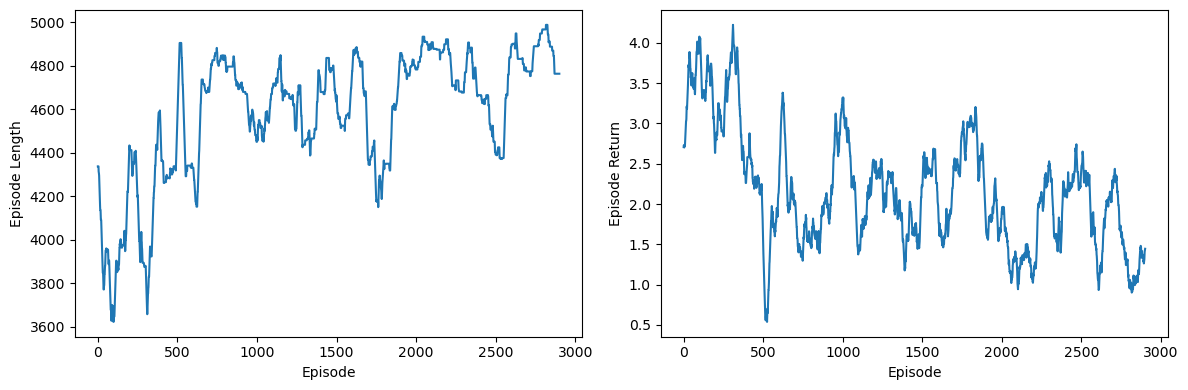

In [80]:
import matplotlib.pyplot as plt
# plot lengths of episodes and returns during training
# smooth the curve by taking a moving average over 100 episodes
window = 100
a = agent7
episode_lengths = np.convolve(a.episode_lengths, np.ones(window), 'valid') / window
episode_returns = np.convolve(a.episode_returns, np.ones(window), 'valid') / window
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(episode_lengths)
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Episode Length')
ax[1].plot(episode_returns)
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Episode Return')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(8,1,figsize=(6,48))
def plotTrace(ax,pos):
    ax.scatter(pos[:,0]/np.pi,pos[:,1]/np.pi,s=0.01) # 画出轨迹
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_aspect('equal')
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['0', '$\pi$', '$2\pi$'])
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])

for i in range(8):
    pos = np.array(agents[i].pos)
    plotTrace(axs[i],pos)


In [ ]:
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(15,6))
pos = np.array(agent7.pos)

phase_size = 5000    
colors = np.arange(len(pos)) // phase_size  # 每个阶段颜色相同

# plot the scatter plot
scatter = ax.scatter(pos[:, 0]/np.pi, pos[:, 1]/np.pi, c=colors, cmap='viridis',s = 0.01)

# add color bar
sm = ScalarMappable(cmap='viridis')
sm.set_array(colors)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Phase')

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_aspect('equal')
ax.set_xticks([-2, -1, 0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['$-2\pi$','$-\pi$','0', '$\pi$', '$2\pi$','$3\pi$','$4\pi$','5$\pi$'])
ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_yticklabels(['$-2\pi$','$-\pi$','0', '$\pi$', '$2\pi$'])


plt.show()


In [7]:
#定义训练函数
def train_agent(agent):
    agent.train(initial_position=np.array([3*np.pi/5,0.0]),initial_direction=np.array([np.pi/2]))
    return agent
# 创建智能体列表
agents = np.array([agent1, agent2, agent3, agent4, agent5, agent6, agent7, agent8])
train_agents = np.frompyfunc(train_agent, 1, 1)
# from multiprocessing import Pool
# if __name__ == '__main__':
#     # 创建一个进程池
#     with Pool(processes=len(agents)) as pool:
#         # 使用map函数来并行训练智能体
#         agents = pool.map(train_agent, agents)

In [4]:
# # 创建环境和智能体
# # 对照
# env1 = CustomEnv(Phi= 0.1, Psi=0.3, B=1, u0=1, D0=0.01, DR=0.001, dt=0.01)
# agent1 = QLearningAgent(env1, learning_rate=0.01, discount_factor=0.999, exploration_prob=0.1, num_episodes=1000, max_steps = 5000)
# # 位移噪声大
# env2 = CustomEnv(Phi= 0.1, Psi=0.3, B=1, u0=1, D0=0.5, DR=0.001, dt=0.01)
# agent2 = QLearningAgent(env2, learning_rate=0.01, discount_factor=0.999, exploration_prob=0.1, num_episodes=1000, max_steps = 5000)
# # 角度噪声大
# env3 = CustomEnv(Phi= 0.1, Psi=0.3, B=1, u0=1, D0=0.01, DR=0.3, dt=0.01)
# agent3 = QLearningAgent(env3, learning_rate=0.01, discount_factor=0.999, exploration_prob=0.1, num_episodes=1000, max_steps = 5000)
# # 探索率小
# env4 = CustomEnv(Phi= 0.1, Psi=0.3, B=1, u0=1, D0=0.01, DR=0.001, dt=0.01)
# agent4 = QLearningAgent(env4, learning_rate=0.01, discount_factor=0.999, exploration_prob=0.001, num_episodes=1000, max_steps = 5000)
# # 学习率大
# env5 = CustomEnv(Phi= 0.1, Psi=0.3, B=1, u0=1, D0=0.01, DR=0.001, dt=0.01)
# agent5 = QLearningAgent(env5, learning_rate=0.05, discount_factor=0.999, exploration_prob=0.1, num_episodes=1000, max_steps = 5000)
# # 单局长度限制小
# env6 = CustomEnv(Phi= 0.1, Psi=0.3, B=1, u0=1, D0=0.01, DR=0.001, dt=0.01)
# agent6 = QLearningAgent(env6, learning_rate=0.01, discount_factor=0.999, exploration_prob=0.1, num_episodes=1000, max_steps = 2000)
# # 学习局数多
# env7 = CustomEnv(Phi= 0.1, Psi=0.3, B=1, u0=1, D0=0.01, DR=0.001, dt=0.01)
# agent7 = QLearningAgent(env7, learning_rate=0.01, discount_factor=0.999, exploration_prob=0.1, num_episodes=3000, max_steps = 5000)
# # 折扣率小
# env8 = CustomEnv(Phi= 0.1, Psi=0.3, B=1, u0=1, D0=0.01, DR=0.001, dt=0.01)
# agent8 = QLearningAgent(env8, learning_rate=0.01, discount_factor=0.9, exploration_prob=0.1, num_episodes=1000, max_steps = 5000)


In [19]:
# train_agents(agents)

Episode 1000/1000 length 3879           

array([<__main__.QLearningAgent object at 0x1169673a0>,
       <__main__.QLearningAgent object at 0x1169d04f0>], dtype=object)

In [85]:
np.arange(1,10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])